In [1]:
import time
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from config import DEVICE, NUM_CLASSES, NUM_EPOCHS , OUT_DIR
from model import create_model
from utils import Averager
from datasets import train_loader, valid_loader,visualize_batch

/home/ubuntu/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of training samples: 155
Number of validation samples: 20



In [2]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for _, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        a_images = list(image.to(DEVICE) for image in images)
        a_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        p_images = list(image.to(DEVICE) for image in images)
        p_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        n_images = list(image.to(DEVICE) for image in images)
        n_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        anchor = model(a_images, a_targets)
        positive = model(p_images, p_targets)
        negative = model(n_images, n_targets)

        anchor_loss = sum(loss for loss in anchor.values())
        positive_loss = sum(loss for loss in positive.values())
        negative_loss = sum(loss for loss in negative.values())

        losses = criterion(anchor_loss, positive_loss, negative_loss)
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [3]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for _, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            anchor_valid = model(images, targets)
            positive_valid = model(images, targets)
            negative_valid = model(images, targets)


        anchor_valid_loss = sum(loss for loss in anchor_valid.values())
        positive_valid_loss = sum(loss for loss in positive_valid.values())
        negative_valid_loss = sum(loss for loss in negative_valid.values())

        losses = criterion(anchor_valid_loss, positive_valid_loss, negative_valid_loss)
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

IndexError: index 8 is out of bounds for axis 0 with size 8

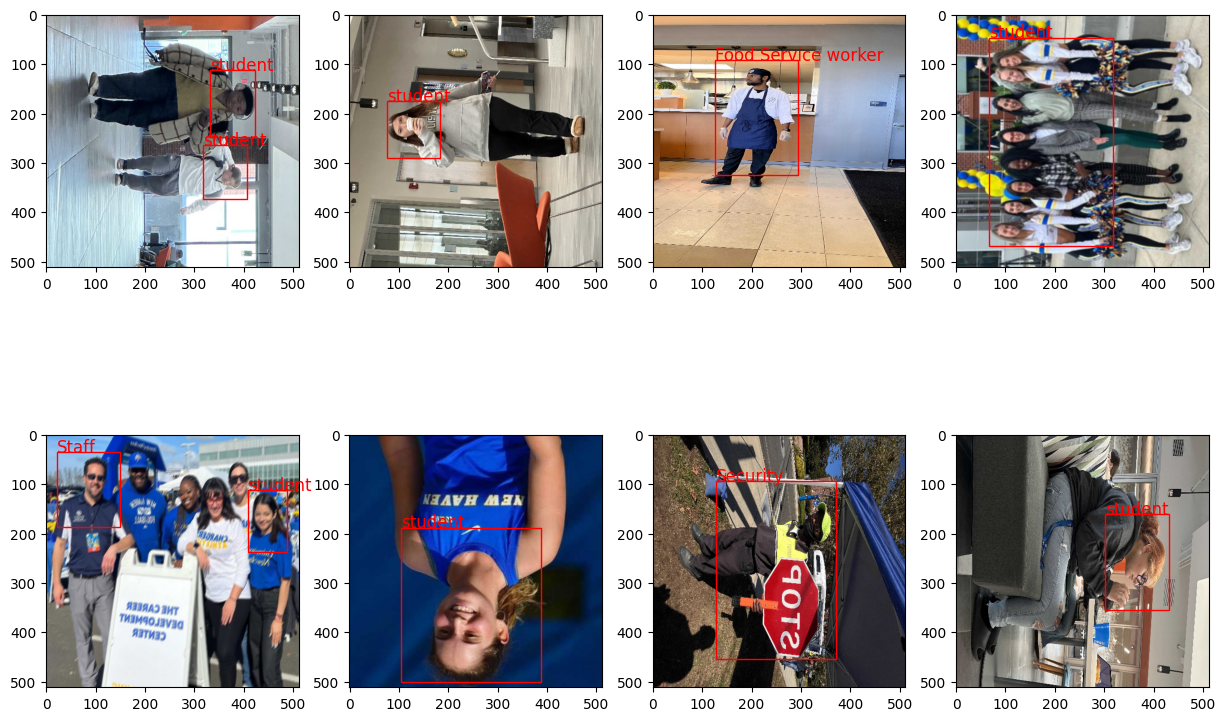

In [4]:
#Visualize batch of images

images, targets = next(iter(train_loader))

visualize_batch(images,targets)

In [5]:
# Model initialization and setup
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)

# Get parameters that require gradient
params = [p for p in model.parameters() if p.requires_grad]

# Define loss function and optimizer
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=0.1, swap=True, reduction='none')
optimizer = torch.optim.SGD(params, lr=1e-5, momentum=0.7, weight_decay=5e-5)

# Initialize loss trackers
train_loss_hist = Averager()
val_loss_hist = Averager()

# Initialize loss lists
train_loss_list = []
val_loss_list = []

# Model name
MODEL_NAME = 'model'

# Training loop
for epoch in range(1):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset loss histories
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Time the training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")


training = 'done'

/home/ubuntu/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



EPOCH 1 of 2
Training


  0%|          | 0/2 [00:06<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.88 GiB. GPU 0 has a total capacty of 22.19 GiB of which 23.50 MiB is free. Including non-PyTorch memory, this process has 22.16 GiB memory in use. Of the allocated memory 18.07 GiB is allocated by PyTorch, and 3.79 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:


figure_1, train_ax = plt.subplots()
figure_2, valid_ax = plt.subplots()
# save the model and plots after training

if training == 'done': 
    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Epochs')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='red')
    valid_ax.set_xlabel('Epochs')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")

    torch.save(model.state_dict(), f"{OUT_DIR}/model.pth")